# "신용카드 사용자 연체 예측 AI 경진대회"의 train 데이터로 군집화 실습 및 마케팅 전략 도출

## <span style="color:orange">데이터 전처리 ALL</span> 

In [1]:
# [0] 필요한 라이브러리 임포트

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import random, warnings
warnings.filterwarnings("ignore")

# 기본 시각화 라이브러리 임포트
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns 
from matplotlib import rc
rc("font", family="AppleGothic")
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"
plt.rcParams['axes.unicode_minus'] = False

# 스케일링.. 등
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 데이터 가져오기
train_df = pd.read_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/train.csv')
train_df.shape

(26457, 20)

In [ ]:
# credit을 0,1 -> 1로 2->2로 해서 좋다 안좋다로만 해석하기!
# train_df['credit'] = train_df['credit'].replace({0: 1, 1: 1})

# occyp_type 결측치 채우기 (살리기)
# train_df.dropna(subset=['occyp_type'], inplace=True)

In [2]:
# [1] ID 변수 생성해서 동일 인물 추리기
train_df['ID'] = \
train_df['child_num'].astype(str) + '_' + train_df['income_total'].astype(str) + '_' +\
train_df['DAYS_BIRTH'].astype(str) + '_' + train_df['DAYS_EMPLOYED'].astype(str) + '_' +\
train_df['work_phone'].astype(str) + '_' + train_df['phone'].astype(str) + '_' +\
train_df['email'].astype(str) + '_' + train_df['family_size'].astype(str) + '_' +\
train_df['gender'].astype(str) + '_' + train_df['car'].astype(str) + '_' +\
train_df['reality'].astype(str) + '_' + train_df['income_type'].astype(str) + '_' +\
train_df['edu_type'].astype(str) + '_' + train_df['family_type'].astype(str) + '_' +\
train_df['house_type'].astype(str) + '_' + train_df['occyp_type'].astype(str)

# [2] 인당 카드 발급 개수 변수 추가하기
train_df['credit_card_count'] = train_df.groupby('ID')['ID'].transform('count')

# [3] ID 중복 처리 (동일 인물이라고 판단)
train_df = train_df.drop_duplicates(subset='ID', keep='first')

# [4] 불필요한 ID 변수 삭제
train_df = train_df.drop('ID', axis=1)
train_df.shape

(8759, 21)

In [3]:
# [5] 의미없는 변수 6개 제거
train_df.drop(['index', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type'], axis=1, inplace=True)
train_df.shape
# 1. index -> 불필요하므로 삭제
# 2. gender
# 3. car
# 4. reality
# 5. child_num
# 6. income_total
# 7. income_type
# 8. edu_type
# 9. family_type
# 10. house_type
# 11. DAYS_BIRTH
# 12. DAYS_EMPLOYED
# 13. FLAG_MOBIL -> 불필요하므로 삭제
# 14. work_phone -> 불필요하므로 삭제
# 15. phone -> 불필요하므로 삭제
# 16. email -> 불필요하므로 삭제
# 17. occyp_type -> 결측치가 너무 많으므로 삭제
# 18. family_size
# 19. begin_month
# 20. credit
# 21. credit_card_count

(8759, 15)

In [4]:
# [6] 이상치 처리(제거)
train_df = train_df[(train_df['family_size'] <= 7)]  # 가족 수가 7 초과인 것들 삭제
train_df = train_df[(train_df['child_num'] <= 5)]  # 자녀 수가 5 초과인 것들 삭제
train_df = train_df.reset_index(drop=True)  # 새롭게 초기화 배열

# [7] 날짜변수 변환 (양수->0 + 음수->양수)
train_df['DAYS_EMPLOYED'] = train_df['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
dates = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for date in dates:
    train_df[date] = np.abs(train_df[date])

In [5]:
# [8] 전략 도출에 필요한 파생변수 5개 생성 [참고로 변수선택은 안할거임 (다 필요함)]

# 1. before_EMPLOYED_year : 고용되지 전까지의 년
train_df['before_EMPLOYED_year'] = (train_df['DAYS_BIRTH'] - train_df['DAYS_EMPLOYED']) // 365

# 2. Age : 나이
train_df['Age'] = train_df['DAYS_BIRTH'] // 365
    
# 3. DAYS_BIRTH_month : 태어난 월 (출생연도의 n월)
train_df['DAYS_BIRTH_month'] = np.floor(train_df['DAYS_BIRTH'] / 30) - ((np.floor(train_df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)

# 4. EMPLOYED : 근속연수
train_df['EMPLOYED'] = train_df['DAYS_EMPLOYED'] // 365

# 5. begin_year : 신용카드 발급 년도
train_df['begin_year'] = train_df['begin_month'] // 12

train_df.shape

(8756, 20)

In [6]:
# [9] Numeric, Category 컬럼 분류

numerical_feats = train_df.dtypes[train_df.dtypes != "object"].index.tolist()
categorical_feats = train_df.dtypes[train_df.dtypes == "object"].index.tolist()
print("Number of Numerical features: ", len(numerical_feats))
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  13
Number of Categorical features:  7


In [7]:
# [10] 카테고리형 데이터 인코딩 진행 (수치형 변환)

# OrdinalEncoder 가져오고
encoder = OrdinalEncoder(categorical_feats)

# 인코딩 적용 [순서 적용]
train_df[categorical_feats] = encoder.fit_transform(train_df[categorical_feats], train_df['credit'])

# 형변환
train_df[categorical_feats] = train_df[categorical_feats].astype('int64')

In [8]:
# [11] 스케일링

# 로그변환 (income_total 왜도가 심함)
# train_df['income_total'] = np.log1p(1+train_df['income_total'])

# 수치형 변수 표준화 (단위 통일)
# 수치형 변수 중 연속형 변수(수입, 날짜)만 표준화를 진행함 (이산형 변수는 표준화를 보통 안함!!)
data = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
scaler = StandardScaler()
train_df[data] = scaler.fit_transform(train_df[data])

# train 인덱스 깔끔하게 초기화
train_df.reset_index(drop=True, inplace=True)
train_df.shape

(8756, 20)

## <span style="color:orange">엘보우 메소드 + 실루엣 분석 + 누적분산설명력 시각화 -> 군집은 4개로 선정!</span>

In [9]:
# 군집화 및 차원축소를 위해 혹시 모르니 데이터 복사해놓기!
train = train_df.copy()

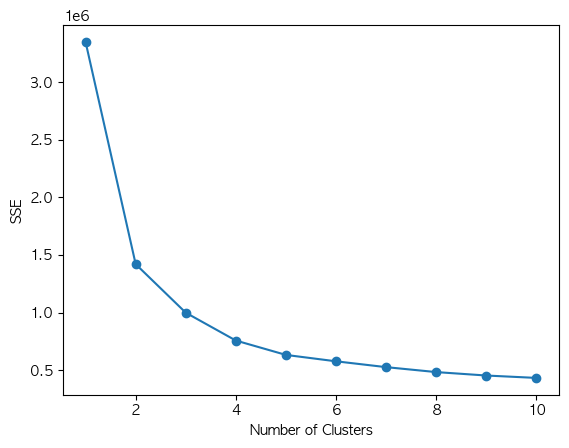

In [10]:
# 군집화 개수 찾기 및 군집 평가하기! (목적변수도 포함해서 진행 - 전략 기획을 위해서!)

# 1. Elbow Method로 K를 구하기!

# SSE 계산을 위한 리스트
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train)
    sse.append(kmeans.inertia_)

# 엘보우 메서드 그래프
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train)
    sil_score = silhouette_score(train, kmeans.labels_)
    sil_scores.append(sil_score)

# 실루엣 분석 그래프
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# 누적된 설명된 분산 그래프를 보고 PCA 주성분 수 결정하기!

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# train_df를 특정 열로만 구성된 NumPy 배열로 변환
# 필요에 따라 특정 열만 선택하여 X에 할당
X = train_df.values

# 데이터를 표준화 (Standardization)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# PCA 모델 생성
pca = PCA()
X_pca = pca.fit_transform(X_standardized)

# 누적된 설명된 분산 시각화
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

## <span style="color:orange">차원축소 및 군집화 실시</span> <span style="color:red"> + "변수마다 군집별 차이, 특징 파악하기"</span>

In [9]:
# 군집화 및 차원축소를 위해 혹시 모르니 데이터 복사해놓기!
train = train_df.copy()

In [10]:
# 차원축소
##### 1. 데이터 형태가 어떻게 되어있을지 시각적으로 확인하기 위해 차원축소 적용 (2, 3차원)
##### 2. PCA를 가장 잘 알고 있기에 설명하기도 편해서 PCA 사용!
##### 3. 최대한 정보의 손실을 줄이기 위해서 정보가 얼마나 줄었는지도 확인하기!

pca = PCA(n_components=2)
pca_result = pca.fit_transform(train)

# PCA 결과를 데이터프레임에 추가
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
train_final = pd.concat([train, train_pca], axis=1)

# PCA 주성분별 설명된 분산의 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print("PC1:", explained_variance_ratio[0])
print("PC2:", explained_variance_ratio[1])

Explained Variance Ratio:
PC1: 0.7813602751145823
PC2: 0.1461351958296993


In [11]:
# 2차원 산점도 시각화
import plotly.express as px

fig = px.scatter(train_final, x='PC1', y='PC2')
fig.show()

In [12]:
# 차원축소를 적용한 데이터로 군집화 후 시각화!

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# K-means 군집화를 위해 PCA 적용
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train)

# PCA 결과를 데이터프레임에 추가
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
train_final = pd.concat([train, train_pca], axis=1)

# K-means 군집화
kmeans = KMeans(n_clusters=4, random_state=42).fit(train_pca[['PC1', 'PC2']])

# 군집 결과를 데이터프레임에 추가
train_final['cluster'] = kmeans.labels_

# K-means 군집 결과 시각화
fig_cluster = px.scatter(train_final, x='PC1', y='PC2', color='cluster', title='K-means Clustering')
fig_cluster.show()

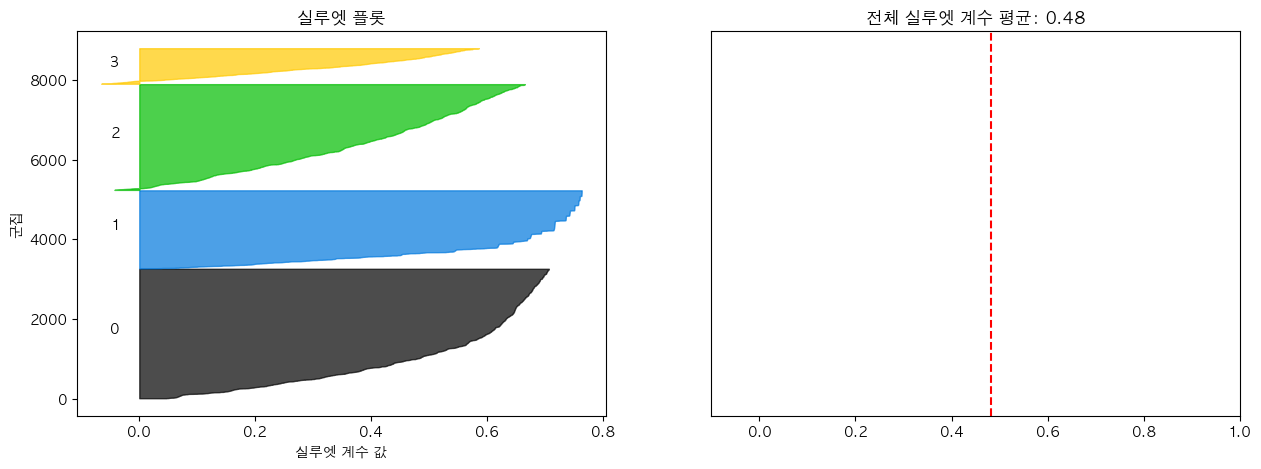

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# K-means 군집화 결과에 대한 실루엣 계수 계산
silhouette_values = silhouette_samples(train_pca[['PC1', 'PC2']], kmeans.labels_)

# 데이터프레임에 실루엣 계수 추가
train_final['silhouette'] = silhouette_values

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 실루엣 플롯
y_lower = 10
for i in range(4):  # 군집의 수에 따라 조절
    ith_cluster_silhouette_values = silhouette_values[train_final['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title("실루엣 플롯")
ax1.set_xlabel("실루엣 계수 값")
ax1.set_ylabel("군집")

# 전체 실루엣 계수 평균 플롯
silhouette_avg = silhouette_score(train_pca[['PC1', 'PC2']], kmeans.labels_)
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.set_yticks([])  # y 축 레이블 제거
ax2.set_xlim([-0.1, 1])
ax2.set_title("전체 실루엣 계수 평균: {:.2f}".format(silhouette_avg))

plt.show()

In [17]:
# 실루엣 계수가 0.4 (스코어) 이상이면 높은거임 ㅇㅇ!

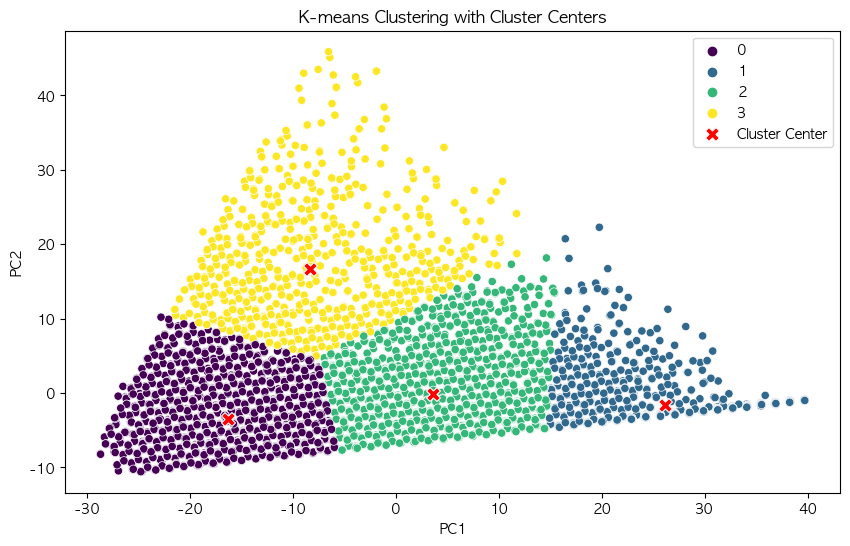

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 군집별 중심 시각화
cluster_centers = kmeans.cluster_centers_
center_df = pd.DataFrame(data=cluster_centers, columns=['PC1', 'PC2'])

# 군집화 결과 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 전체 데이터의 2차원 산점도
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=train_final, palette='viridis', ax=ax)

# 군집 중심 시각화
sns.scatterplot(x='PC1', y='PC2', data=center_df, color='red', marker='X', s=100, ax=ax, label='Cluster Center')

plt.title('K-means Clustering with Cluster Centers')
plt.legend()
plt.show()

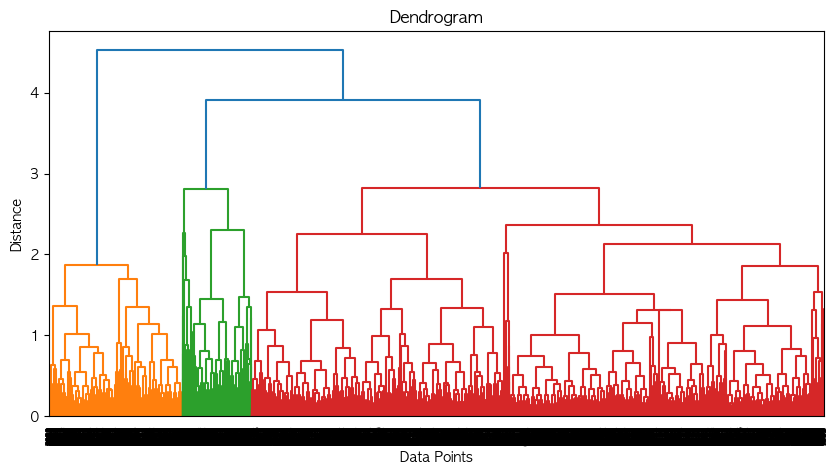

In [16]:
# 계층적 군집화 (덴드로그램으로 시각화)
# 🔥 이거 여기서 끝내는게 아니고 최적의 트리 수 넣어서 군집 결과 봐야함!

import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'train_df' is your DataFrame
train = train_df.copy()

# Standardize the data before PCA
scaler = StandardScaler()
train_standardized = scaler.fit_transform(train)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_standardized)

# Create a DataFrame with PCA results
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Hierarchical clustering
Z = hierarchy.linkage(train_pca, method='average', metric='euclidean')

# Dendrogram visualization
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

train = train_df.copy()

# K-means 대신 GMM 군집화를 위해 PCA 적용
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train)

# PCA 결과를 데이터프레임에 추가
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
train_final = pd.concat([train, train_pca], axis=1)

# GMM 군집화
gmm = GaussianMixture(n_components=4, random_state=42).fit(train_pca[['PC1', 'PC2']])

# 군집 결과를 데이터프레임에 추가
train_final['cluster'] = gmm.predict(train_pca[['PC1', 'PC2']])

# GMM 군집 결과 시각화
fig_cluster_gmm = px.scatter(train_final, x='PC1', y='PC2', color='cluster', title='GMM Clustering')
fig_cluster_gmm.show()

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# 데이터 복사
train = train_df.copy()

# PCA 적용
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train)

# PCA 결과를 데이터프레임에 추가
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
train_final = pd.concat([train, train_pca], axis=1)

# DBSCAN 군집화
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(train_final[['PC1', 'PC2']])

# 군집 결과를 데이터프레임에 추가
train_final['cluster'] = dbscan.labels_

# DBSCAN 군집 결과 시각화
fig_cluster_dbscan = px.scatter(train_final, x='PC1', y='PC2', color='cluster', title='DBSCAN Clustering')
fig_cluster_dbscan.show()

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

# 데이터 복사
train = train_df.copy()

# PCA 적용
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train)

# PCA 결과를 데이터프레임에 추가
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
train_final = pd.concat([train, train_pca], axis=1)

# StandardScaler를 사용하여 PCA 결과를 표준화
scaler = StandardScaler()
scaled_pca_result = scaler.fit_transform(train_pca[['PC1', 'PC2']])
train_final[['PC1', 'PC2']] = scaled_pca_result

# MeanShift 군집화
meanshift = MeanShift(bandwidth=0.5).fit(train_final[['PC1', 'PC2']])

# 군집 결과를 데이터프레임에 추가
train_final['cluster'] = meanshift.labels_

# MeanShift 군집 결과 시각화
fig_cluster_meanshift = px.scatter(train_final, x='PC1', y='PC2', color='cluster', title='Meanshift Clustering')
fig_cluster_meanshift.show()

In [ ]:
# [시각화] PCA(2) + K-means(4) 했다는 가정 하에 진행

import matplotlib.pyplot as plt
import seaborn as sns

# 최종 데이터로 변수마다 클러스터 별 특징 파악하기
train_fin = train_final.copy()

# pc1, pc2, cluster를 제외한 20개의 변수 리스트
variables_to_plot = train_fin.columns.difference(['PC1', 'PC2', 'cluster'])

# 클러스터 별로 데이터 분포를 히스토그램으로 그리기
for variable in variables_to_plot:
    plt.figure(figsize=(12, 6))
    for cluster_label in train_fin['cluster'].unique():
        sns.histplot(train_fin[train_fin['cluster'] == cluster_label][variable], label=f'Cluster {cluster_label}', kde=True)

    plt.title(f'Distribution of {variable} by Cluster')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## <span style="color:orange">(차원축소X) 군집화만 실시</span> <span style="color:red"> + "변수마다 군집별 차이, 특징 파악하기"</span>

In [13]:
# 군집화 및 차원축소를 위해 혹시 모르니 데이터 복사해놓기!
train = train_df.copy()

In [14]:
# 클러스터링 구성 변수 생성!! [PCA 안하고!] [당연히 목적변수 포함 진행!]
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42).fit(train)
train['cluster'] = kmeans.predict(train)

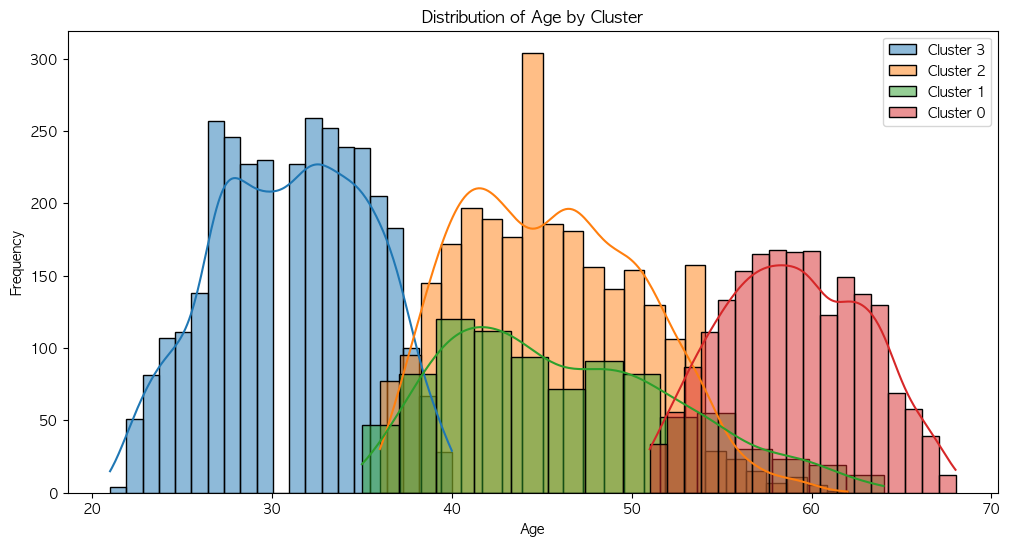

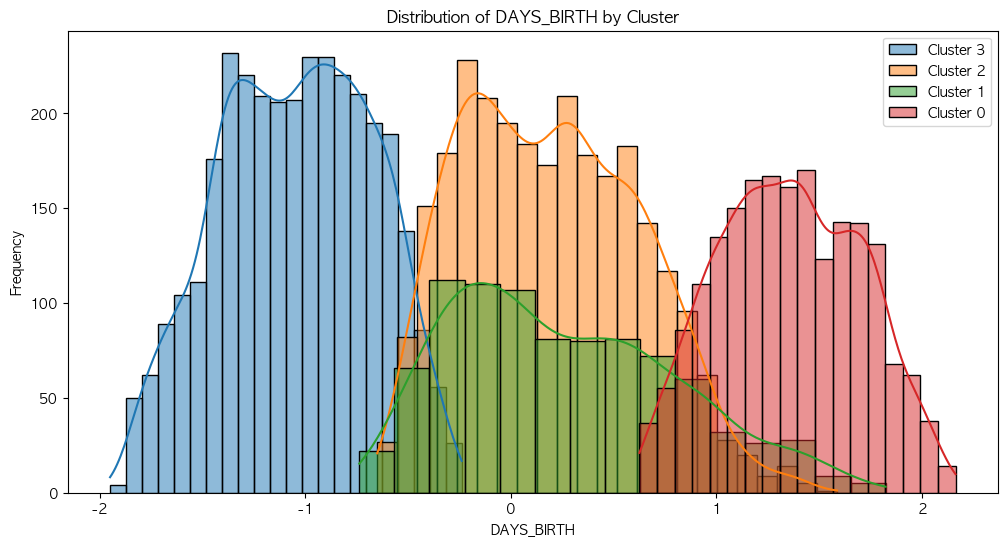

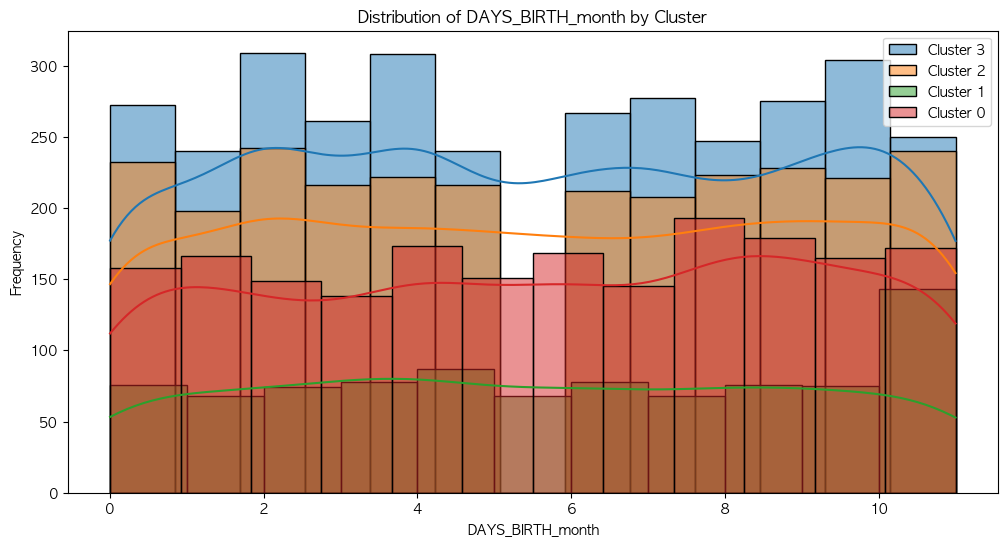

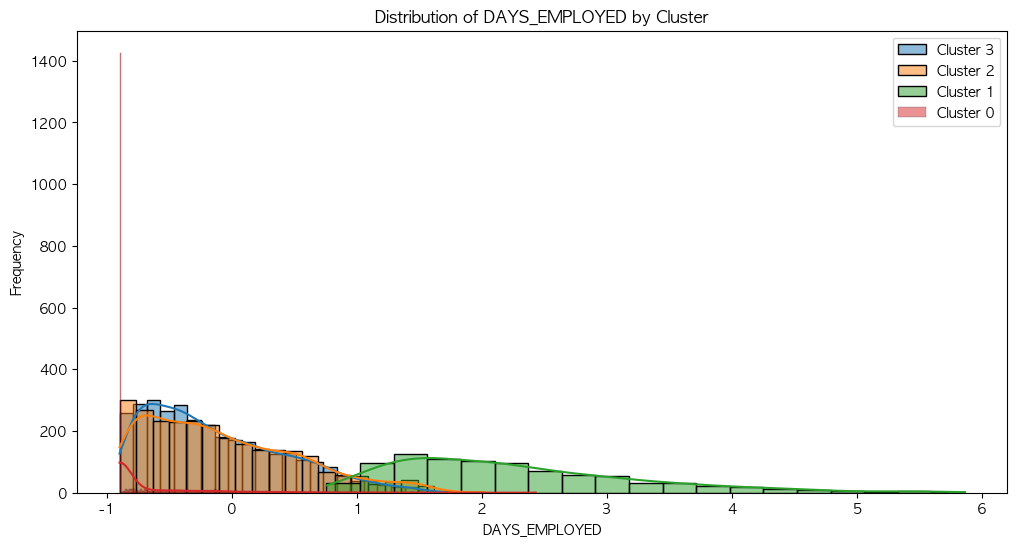

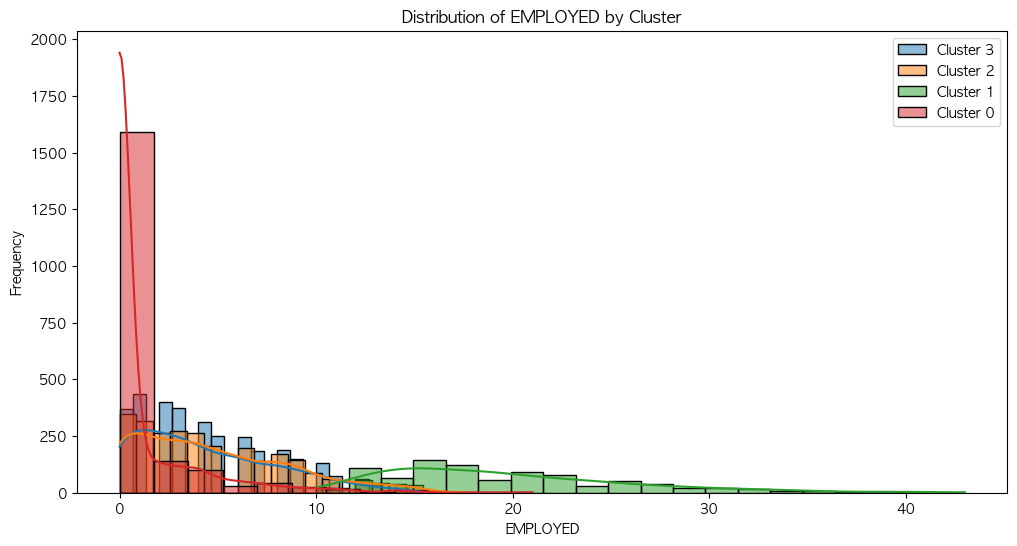

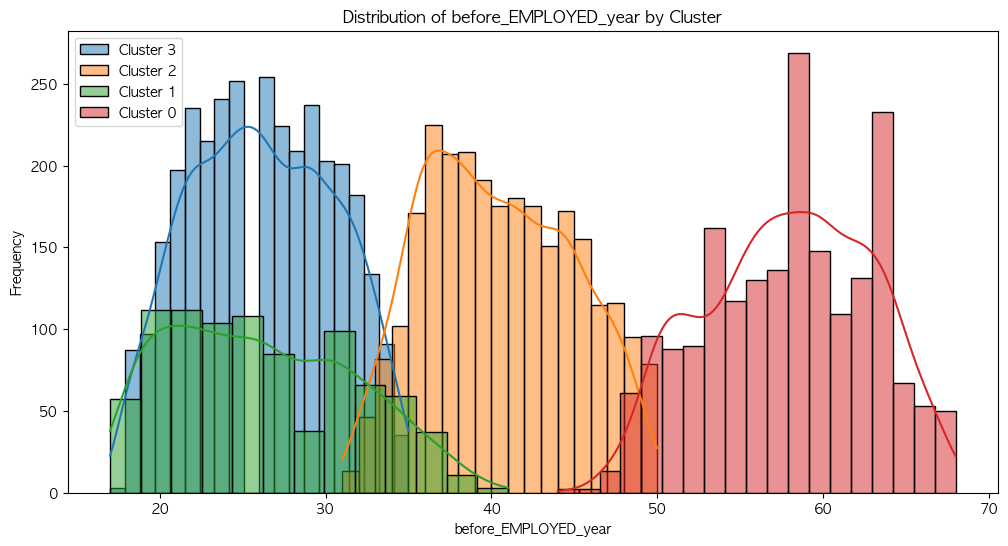

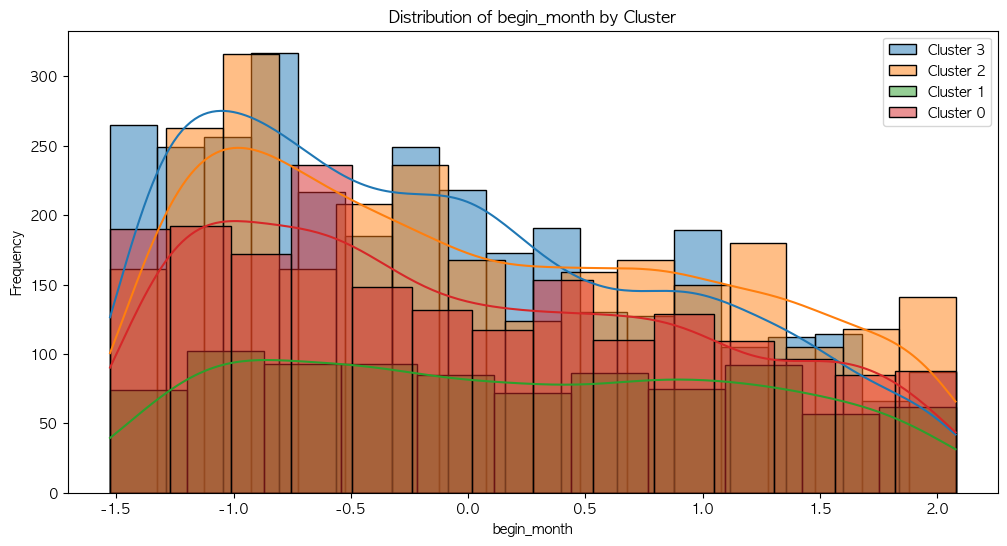

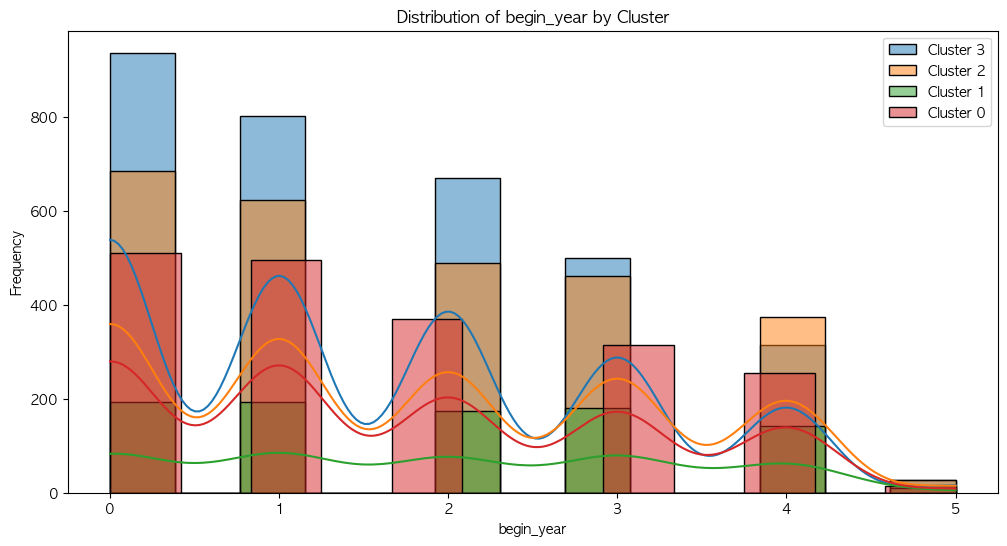

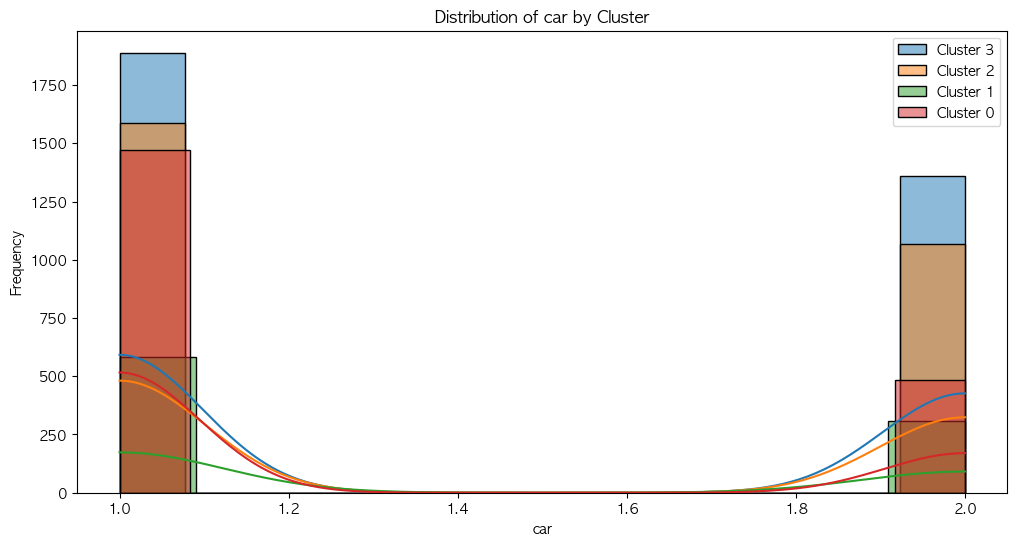

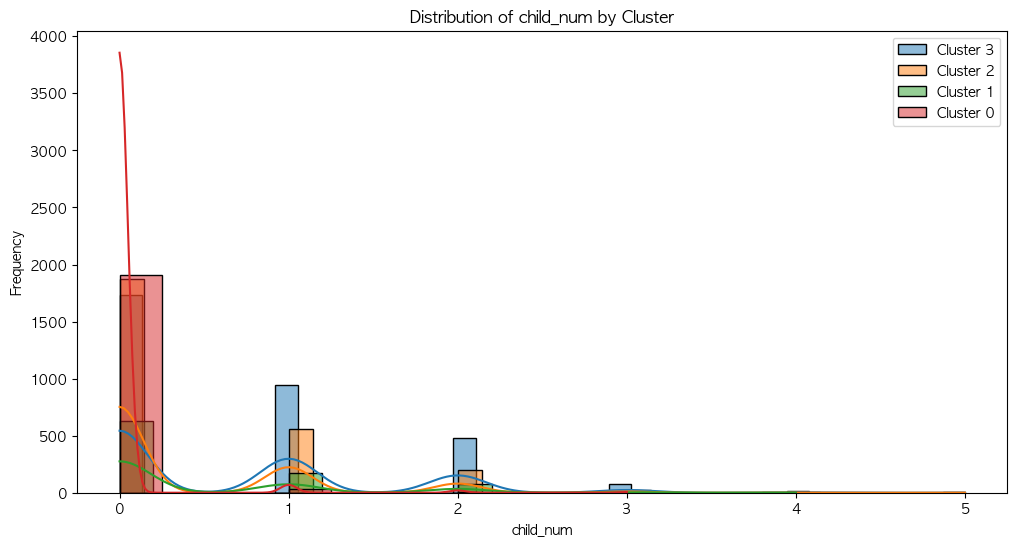

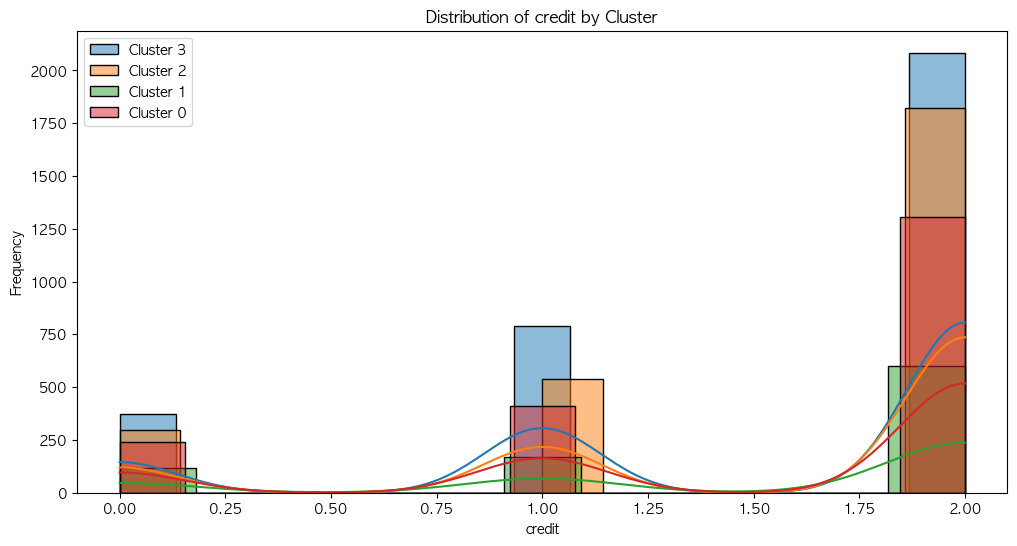

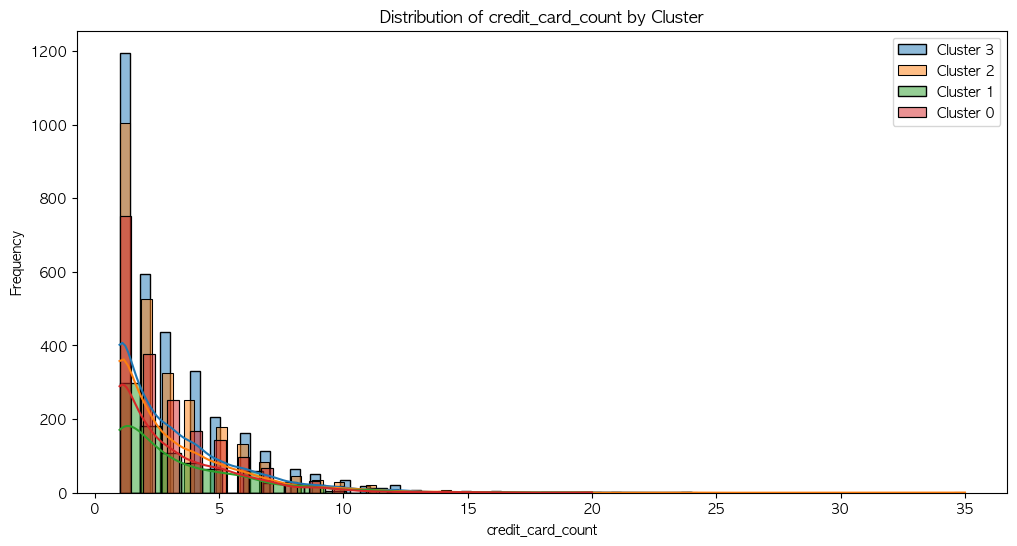

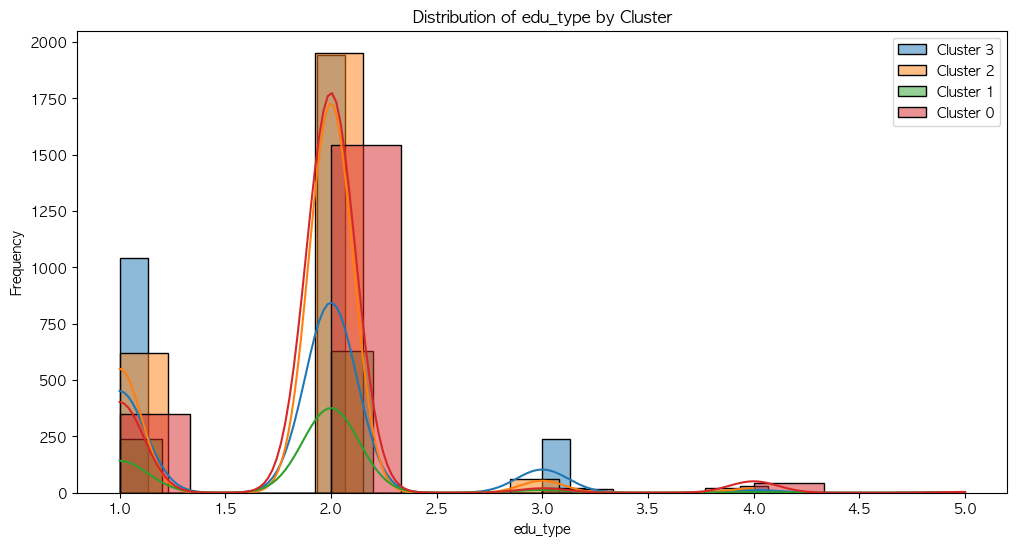

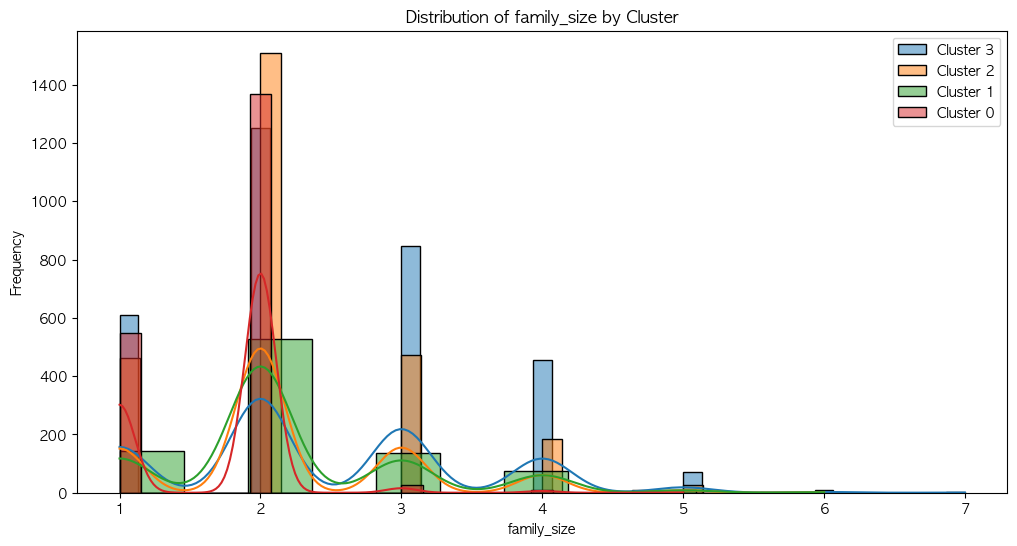

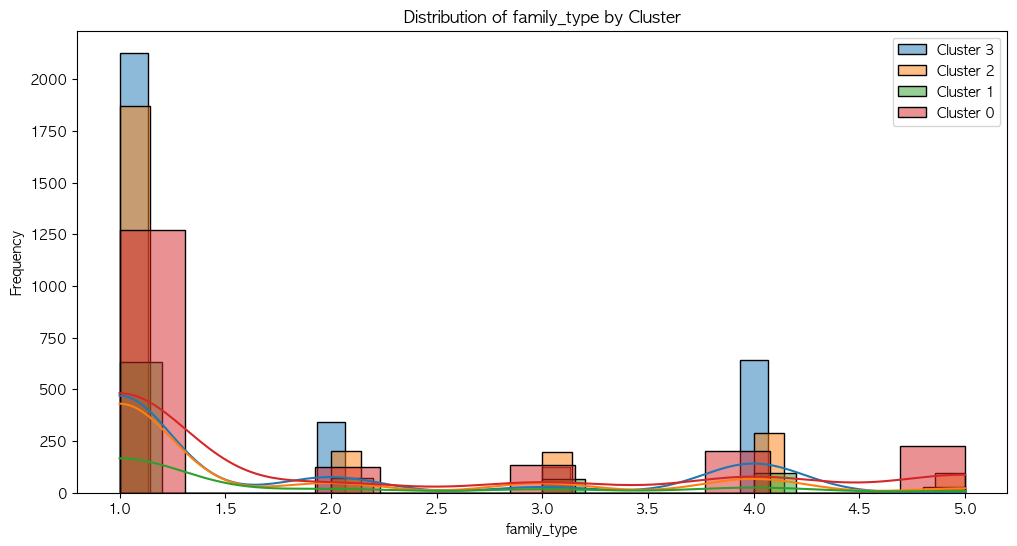

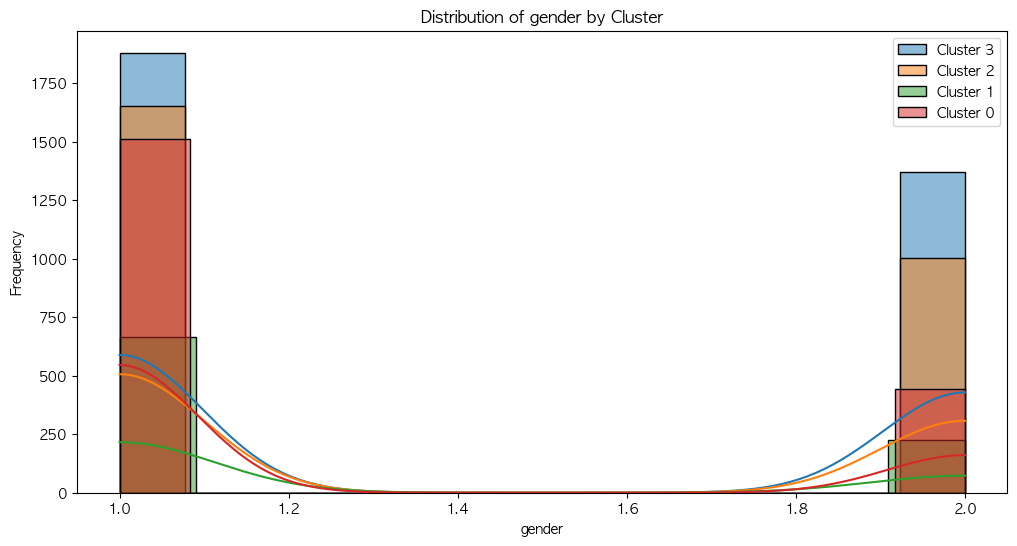

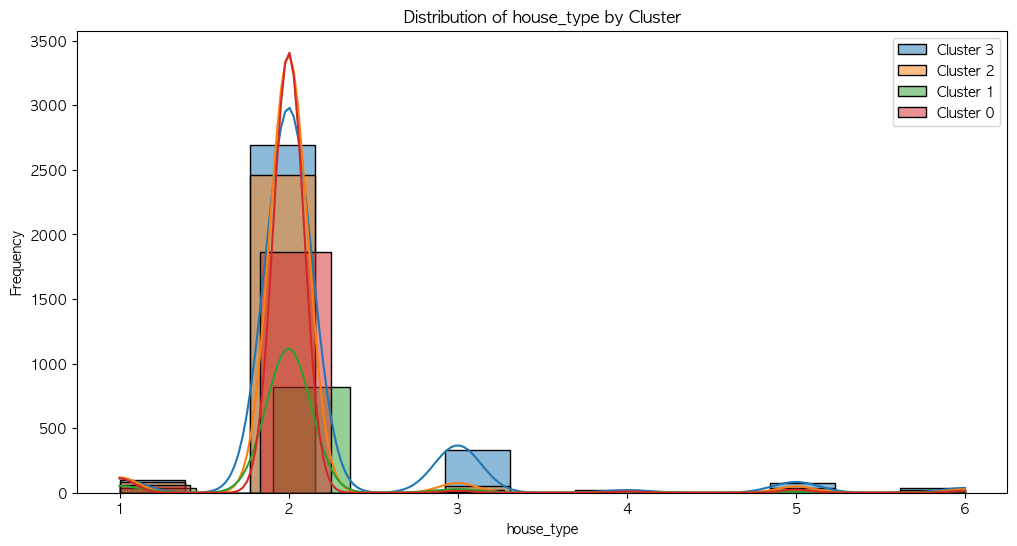

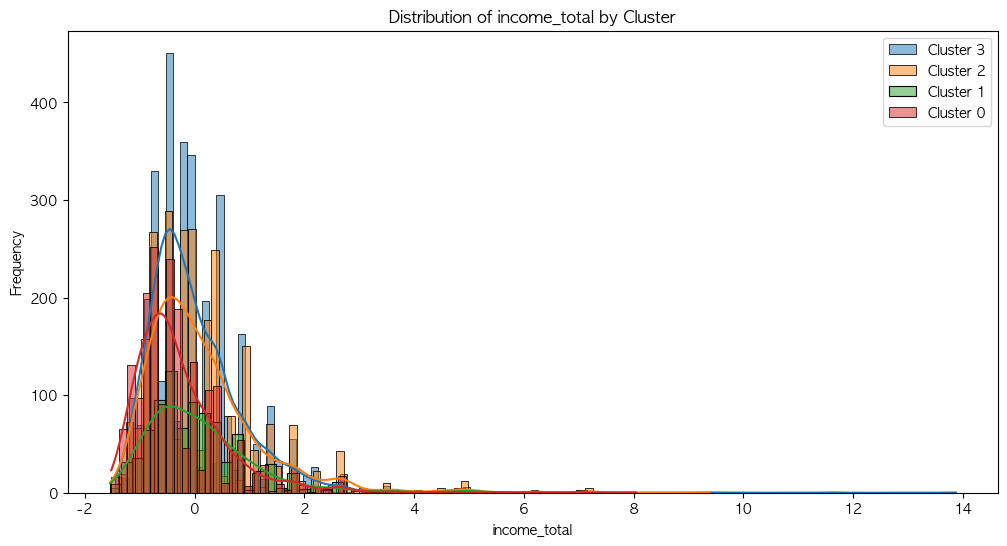

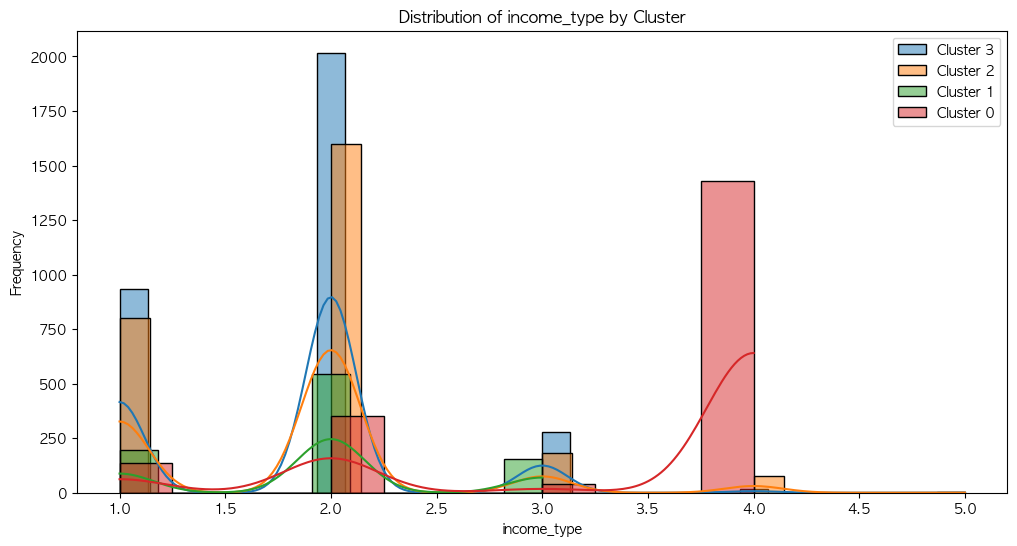

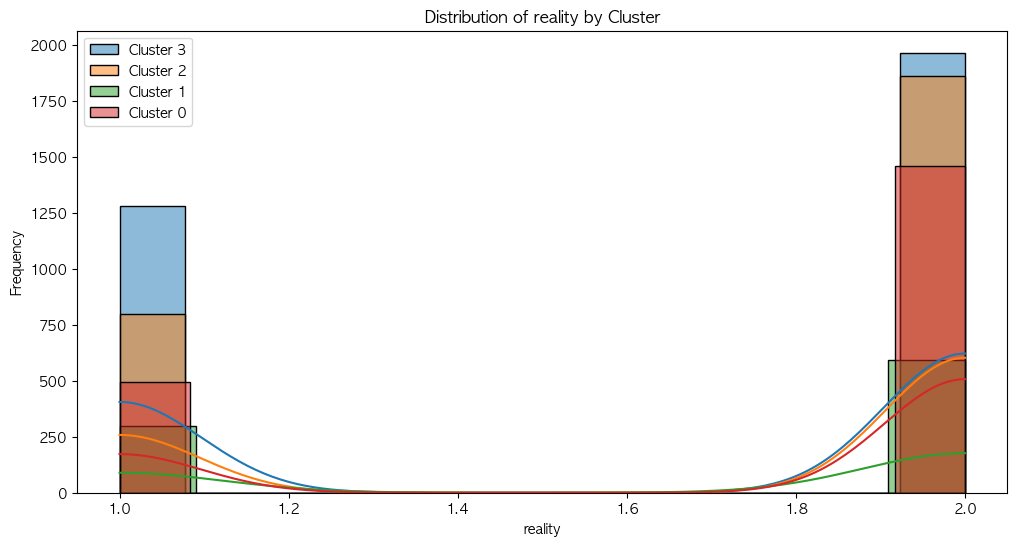

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 'cluster' 변수를 제외한 나머지 변수들의 리스트
variable_list = train.columns.difference(['cluster'])

# 변수들에 대한 히스토그램 그리기
for variable in variable_list:
    plt.figure(figsize=(12, 6))
    for cluster_label in train['cluster'].unique():
        sns.histplot(train[train['cluster'] == cluster_label][variable], label=f'Cluster {cluster_label}', kde=True)

    plt.title(f'Distribution of {variable} by Cluster')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## <span style="color:orange">변수의 특징 별로 수동적인 군집(타겟) 설정하기</span> <span style="color:red"> + "변수마다 군집별 차이, 특징 파악하기"</span>

In [39]:
# 군집화 및 차원축소를 위해 혹시 모르니 데이터 복사해놓기!
train = train_df.copy()

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                8756 non-null   int64  
 1   car                   8756 non-null   int64  
 2   reality               8756 non-null   int64  
 3   child_num             8756 non-null   int64  
 4   income_total          8756 non-null   float64
 5   income_type           8756 non-null   int64  
 6   edu_type              8756 non-null   int64  
 7   family_type           8756 non-null   int64  
 8   house_type            8756 non-null   int64  
 9   DAYS_BIRTH            8756 non-null   float64
 10  DAYS_EMPLOYED         8756 non-null   float64
 11  family_size           8756 non-null   float64
 12  begin_month           8756 non-null   float64
 13  credit                8756 non-null   float64
 14  credit_card_count     8756 non-null   int64  
 15  before_EMPLOYED_year 

In [29]:
# gender (성별)
# car (차 소유 여부)
# reality (부동산 소유 여부)
# child_num (자녀 수)
# income_total (총 소득)
# income_type (소득 유형)
# edu_type (교육 수준)
# family_type (가족 유형)
# house_type (주택 유형)
# DAYS_BIRTH (생일로부터의 일수)
# DAYS_EMPLOYED (고용일로부터의 일수)
# family_size (가족 규모)
# begin_month (신용카드 발급 월)
# credit (신용 등급)
# credit_card_count (신용카드 보유 개수)
# before_EMPLOYED_year (고용 전 경력 연수)
# Age (나이)
# DAYS_BIRTH_month (태어난 월)
# EMPLOYED (근속 연수)
# begin_year (신용카드 발급 연도)

In [40]:
for variable in train.columns:
    counts = train[variable].value_counts()
    print(f"\n{variable}:\n{counts}")


gender:
1    5713
2    3043
Name: gender, dtype: int64

car:
1    5534
2    3222
Name: car, dtype: int64

reality:
2    5880
1    2876
Name: reality, dtype: int64

child_num:
0    6144
1    1708
2     769
3     116
4      16
5       3
Name: child_num, dtype: int64

income_total:
135000.0    1022
112500.0     768
180000.0     761
157500.0     751
225000.0     673
            ... 
418500.0       1
30150.0        1
231750.0       1
208350.0       1
191700.0       1
Name: income_total, Length: 249, dtype: int64

income_type:
2    4512
1    2066
4    1519
3     656
5       3
Name: income_type, dtype: int64

edu_type:
2    6067
1    2249
3     334
4     100
5       6
Name: edu_type, dtype: int64

family_type:
1    5904
4    1227
2     739
3     521
5     365
Name: family_type, dtype: int64

house_type:
2    7831
3     414
1     284
5     127
6      68
4      32
Name: house_type, dtype: int64

DAYS_BIRTH:
13788    5
20836    5
10425    5
14887    4
14775    4
        ..
23478    1
13271    1

In [41]:
train.describe()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,credit,credit_card_count,before_EMPLOYED_year,Age,DAYS_BIRTH_month,EMPLOYED,begin_year
count,8756.000000,8756.000000,8756.00000,8756.000000,8.756000e+03,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000,8756.000000
mean,1.347533,1.367976,1.67154,0.419484,1.818929e+05,2.186958,1.806190,1.790544,2.096734,15975.970534,2083.921654,2.178735,25.408177,1.546254,3.020900,37.554020,43.265875,5.537003,5.297168,1.668913
std,0.476214,0.482282,0.46968,0.726290,1.004623e+05,0.986427,0.556166,1.275068,0.582935,4242.078014,2324.340293,0.903150,16.646989,0.695278,2.560143,13.319856,11.625476,3.462568,6.299137,1.391299
min,1.000000,1.000000,1.00000,0.000000,2.700000e+04,1.000000,1.000000,1.000000,1.000000,7705.000000,0.000000,1.000000,0.000000,0.000000,1.000000,17.000000,21.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.00000,0.000000,1.125000e+05,2.000000,1.000000,1.000000,2.000000,12407.500000,348.000000,2.000000,11.000000,1.000000,1.000000,26.000000,33.000000,3.000000,0.000000,0.000000
50%,1.000000,1.000000,2.00000,0.000000,1.575000e+05,2.000000,2.000000,1.000000,2.000000,15607.000000,1379.000000,2.000000,23.000000,2.000000,2.000000,35.000000,42.000000,6.000000,3.000000,1.000000
75%,2.000000,2.000000,2.00000,1.000000,2.250000e+05,2.000000,2.000000,2.000000,2.000000,19516.250000,3013.750000,3.000000,39.000000,2.000000,4.000000,47.000000,53.000000,9.000000,8.000000,3.000000
max,2.000000,2.000000,2.00000,5.000000,1.575000e+06,5.000000,5.000000,5.000000,6.000000,25152.000000,15713.000000,7.000000,60.000000,2.000000,35.000000,68.000000,68.000000,11.000000,43.000000,5.000000


In [1]:
# 이렇게 봐도 되고
# "최종본"처럼 한글을 보려면 중간에 데이터프레임 저장 후 concat해줘도 됨.
# 물론 인코딩한 방식을 애초에 알고 있으면 다시 입히거나 나만 알고 진행하거나 해도 됨.